In [8]:
from src.graph import *
from src.mdp import *
from src.policy import *
from src.nyc import *

import matplotlib.pyplot as plt
import numpy as np
import sklearn

In this notebook we attempt to perform a policy improvement algorithm for our MDP. Rather than starting with a random policy (zero value functions), we start from the greedy policy we previously defined to get faster convergence

In [2]:
mdp = MDP['nyc']
pi_0 = policy_greedy(mdp)

The hardest part of policy iteration is of course policy evaluation. In this step we must approximate for the previous policy $\pi_{k-1}$ a value function $V_{\pi_{k-1}}(s) \rightarrow \mathbb{R}$ that gives approximate expected rewards for every state. This is done in the course using the Bellman equations
\[V_{\pi_{k-1}}(s) = \sum r(s, a) + \gamma T(s, a, s')V(s')\]
which you can either (1) solve directly as a system of linear equations or (2) approximate iteratively. Either approach would be daunting in this case for two reasons:

* Our state space is exponentially large in the number of available drivers. In the nyc case we have approx $60^{15}$ states which is clearly too many to compute values for each
* As this is a reinforcement learning setting, we do not know the transition function of the new rides coming in. In fact they may not even be fully Markov (dependence between one ride and the next), but this is another story.

### Our solution

We do this by approximating $V_{\pi_{k-1}}$ with a model $\hat V$ and fitting it on sample data. We first use a linear model, then a neural network. We make the simplification of only looking $t$ steps in the future rather than using discounting, and let successive iterations of policy improvement reach convergence. So we fit

\[V_{\pi_{k-1}}(s) \approx \hat V (s)\approx r(s, a) + \gamma r(s', a') + \gamma^2(r'', a'') + \dots + \gamma^t r(s^{(t)}, a^{(t)})\]

the RHS is approximately $r(s, a) + \gamma T(s, a, s')V(s')$, where $[s, a, s', a', \dots]$ is an episode we experience following policy $\pi_{k-1}$. We experiment with different values of $t$ to see what leads to good enough convergence.

#### Building the training set (s, V(s)) for our model

In [2]:
def get_training_set(policy, mdp, no_iter=1000, no_ep=50, t=3, gamma=0.9):
    '''Generates a set of samples (s, V(s)) for the given policy
    no_iter: how many s in the training set
    no_episodes: how many episodes to run for each s to approximate V(s)
    t: lookforward window in the future
    '''
    
    samples = []
    for _ in range(no_iter):
        s = mdp.get_starting_state()
        avg_rw = 0
        
        for __ in range(no_ep):
            # Generate an episode and sum up the discounted rewards
            cur_s = s
            rw = 0
            for ____ in range(t):
                a = policy(cur_s)
                rw = rw * gamma + mdp.R(cur_s, a)
                cur_s = mdp.T(cur_s, a)
            avg_rw += rw / no_ep
        
        samples.append((s, avg_rw))
    return samples

# For details on our efficient representation of a state as a (N,) shaped array,
#     please consult src/mdp.py

def get_arrays(policy, mdp, no_iter=1000, no_ep=10, t=3, gamma=0.9):
    
    samples = get_training_set(policy, mdp, no_iter=no_iter, 
                               no_ep=no_ep, t=t, gamma=gamma)
    y = np.array([s[1] for s in samples])
    X = np.vstack([s[0].to_array(mdp) for s in samples])
    return X, y

In [19]:
X, y = get_arrays(pi_0, mdp, 100000)
X_ts, y_ts = get_arrays(pi_0, mdp, 10000)

In [20]:
X.shape, y.shape

((100000, 64), (100000,))

In [22]:
# Save to data folder for later use
for st, ar in [('X', X), ('y', y), ('X_ts', X_ts), ('y_ts', y_ts)]:
    np.save('data/'+st+'.npy', ar)

#### Fitting estimators and generating the new policy

In [45]:
# Loading training and test data from file
X = np.load('data/X.npy')
y = np.load('data/y.npy')
X_ts = np.load('data/X_ts.npy')
y_ts = np.load('data/y_ts.npy')

In [29]:
from sklearn.linear_model import LinearRegression

# Try how well a Linear model is doing
m = LinearRegression()
print("Train R2:", m.fit(X, y).score(X, y))
print("Test R2: ", m.fit(X, y).score(X_ts, y_ts))

Train R2: 0.3002199162223307
Test R2:  0.255204547161746


In [ ]:
# I like this, not overfitting too badly, much better performance than random
#   this is great!

In [58]:
# Try a Neural Network instead
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

scale_X = StandardScaler().fit(X)
X_s = scale_X.transform(X)
X_s_ts = scale_X.transform(X_ts)

n = MLPRegressor(hidden_layer_sizes=(30, 20, 15), activation="relu", max_iter=200)
n.fit(X_s, -y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(30, 20, 15), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [59]:
print("Train R2:", n.score(X_s, -y))
print("Test R2: ", n.score(X_s_ts, -y_ts))

Train R2: 0.36368992958561164
Test R2:  0.2698395935997815


In [ ]:
# Better! But need to do more hyperparameter tuning...

In [63]:
def gen_Vhat(estimator, mdp):
    def Vhat(s):
        '''Return approximation of V by the estimator'''
        return estimator.predict(s.to_array(mdp).reshape(1, -1))[0]
    return Vhat

def gen_Vhat_nn(net, scaler, mdp):
    def Vhat(s):
        X_s = scaler.transform(s.to_array(mdp).reshape(1, -1))
        return -net.predict(X_s)[0]
    return Vhat

def policy_improvement(pi, Vhat, mdp, gamma=0.9):
    '''Return a policy that selects a that maximizes r(s, a) + gamma Vhat(s')'''
    def C(s, a):
        #print("Wd be", mdp.C(s, a), " now is ", mdp.C(s, a) - gamma * Vhat(mdp.T(s, a)))
        return mdp.C(s, a) - gamma * Vhat(mdp.T(s, a))
    def fn(s):
        mincost = 9999999
        besta = None
        for a in range(s.K):
            cs = C(s, a)
            if cs < mincost:
                mincost = cs
                besta = a
        return besta
    return Policy(fn)

In [107]:
Vhat_0 = gen_Vhat(LinearRegression().fit(X, y), mdp)
pi_1 = policy_improvement(pi_0, Vhat_0, mdp)

#### Evaluating the new pi_1

In [108]:
# We have a new pi_1 which mostly predicts the same things as pi_0 = greedy_policy
s = mdp.get_starting_state()
pi_1(s), pi_0(s)

(10, 10)

In [109]:
tries = 100
different = 0
for _ in range(tries):
    s = mdp.get_starting_state()
    if pi_1(s) != pi_0(s):
        different += 1
print("Out of", tries, "tries, pi_1(s) != pi_0(s) in", different, "of them")

Out of 100 tries, pi_1(s) != pi_0(s) in 26 of them


In [110]:
no_eval = 50000
print("pi_0 avg waiting time (loss):", round(mdp.eval(pi_0, no_iter=10*no_eval, return_pct_trip=True), 2), "pct trip time")
print("pi_1 avg waiting time (loss):", round(mdp.eval(pi_1, no_iter=no_eval, return_pct_trip=True), 2), "pct trip time")

pi_0 avg waiting time (loss): 38.9 pct trip time
pi_0 avg waiting time (loss): 36.18 pct trip time


#### With a NN instead

In [65]:
Vhat_0_nn = gen_Vhat_nn(n, scale_X, mdp)
pi_1_nn = policy_improvement(pi_0, Vhat_0_nn, mdp)

In [72]:
no_eval = 5000
print("pi_1_nn avg waiting time (loss):", round(mdp.eval(pi_1_nn, no_iter=no_eval, return_pct_trip=True), 2), "pct trip time")

pi_1_nn avg waiting time (loss): 29.15 pct trip time


#### Putting this all together

In [16]:
def get_new_pi(pi, mdp, estimator, gamma=0.9,
               no_iter=1000, no_ep=10, t=3):
    '''Generates pi_k+1 from pi_k using policy improvement.
    Other parameters are used to generate the training set for the estimator.
    Please make sure your estimator does not have warm_start=True.
    '''
    
    X, y = get_arrays(pi, mdp, no_iter=no_iter, no_ep=no_ep, t=t, gamma=gamma)
    model = sklearn.base.clone(estimator).fit(X, y)
    Vh = gen_Vhat(model, mdp=mdp)
    return policy_improvement(pi, Vh, mdp=mdp, gamma=0.9)

In [39]:
from sklearn.linear_model import LinearRegression

# Try this out multiple times starting from random policy
mdp = MDP['nyc']
pi = {0: policy_random}
ks = 10

for k in range(ks):
    pi[k + 1] = get_new_pi(pi[k], mdp, LinearRegression(), no_iter=5000, no_ep=1, t=1)
    #print("Iteration done")

print("Evaluating")
evals = [mdp.eval(pi[k], no_iter=3000, return_pct_trip=True) for k in range(ks+1)]

Evaluating


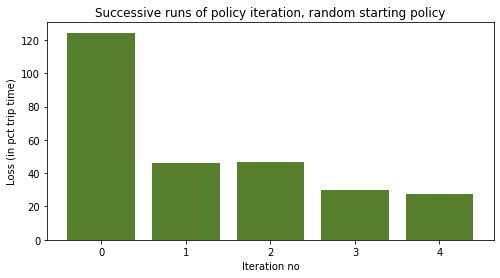

In [43]:
lb = range(5)

plt.figure(figsize=(8, 4))

plt.bar(lb, evals[:5], color='#557f2d')
plt.xlabel("Iteration no")
plt.ylabel("Loss (in pct trip time)")
plt.title("Successive runs of policy iteration, random starting policy")

plt.xticks(lb, lb)

plt.savefig("img/iterations.png")